In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from utils import *
from collections import Counter
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding


Using TensorFlow backend.


In [2]:
df = pd.read_excel('data/sebrae.xls')
print(df.shape)
df.head(3)

(1286, 17)


,N. da manifestação,Situação,Área de tratamento,Relato,Natureza,Assunto principal,Sub assunto 1,Sub assunto 2,Sub assunto 3,Produto serviço,Canal de entrada,Cliente interno,Cidade do cliente,UF do cliente,Dt. cadastro manifestação,Previsão de conclusão,Tempo resposta
0,76432018,Finalizada,Sebrae/AC,Boa tarde.\n\nDesde algum tempo que acompanho ...,Solicitação,Atendimento Sebrae,Online/Chat,Cadastro,NaN,NaN,Portal,Não,NaN,NaN,25/10/2018 13:25,04/11/2018,6
1,85632018,Finalizada,Sebrae/AC,Sou Julio Cesar Freitas moro na cidade de Rio ...,Reclamação,Atendimento Sebrae,Presencial,Falta de retorno,NaN,NaN,Portal,Não,Rio Branco,AC,06/12/2018 12:15,16/12/2018,15
2,87912018,Finalizada,Sebrae/AC,o meu programa de nfe nao esta mais instalando,Solicitação,Emissor de Nota Fiscal - NF-e/CT-e,NaN,NaN,NaN,NaN,Chatbot,Não,NaN,AC,19/12/2018 18:54,29/12/2018,2


### Distribuição das manifestações por categoria

Solicitação    507
Reclamação     454
Elogio         204
Sugestão        78
Crítica         43
Name: Natureza, dtype: int64


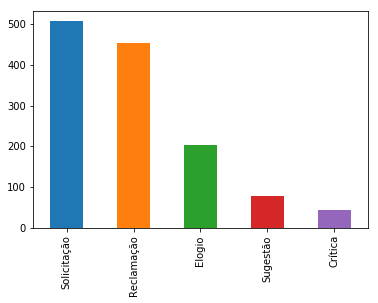

In [3]:
print(df.Natureza.value_counts())
df.Natureza.value_counts().plot.bar()

In [4]:
df['class'] = df.Natureza.replace({'Solicitação': 0, 'Reclamação': 1, 'Elogio': 2,'Sugestão': 3,'Crítica': 4})

#### Significado das classes
* 0 - Solicitação
* 1 - Reclamação
* 2 - Elogio
* 3 - Sugestão
* 4 - Crítica

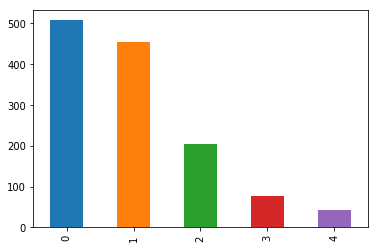

In [5]:
df['class'].value_counts().plot.bar()

### Amostra das manifestações

In [6]:
print("Reclamação:")
for valor in df.loc[df['class']==1]['Relato'][:1].values:
    print(valor)
print("")    

print("Elogio:")
for valor in df.loc[df['class']==2]['Relato'][:1].values:
    print(valor)
print("")    

print("Crítica:")
for valor in df.loc[df['class']==4]['Relato'][:1].values:
    print(valor)


Reclamação:
Sou Julio Cesar Freitas moro na cidade de Rio Branco e venho manifestar minha insatisfação com o atendimento no Sebrae-AC.
Essa é a terceira vez em 2 anos que procuro o Sebrae local buscando  orientações e informações sobre como iniciar um negócio que idealizado, mas não tenho tido “sorte”.
O processo de atendimento parece não ter um fluxo padronizado. A impressão que tive, nas vezes que procurei atendimento, é que existe um enorme abismo entre o serviço propagandeado pelo Sebrae e a realidade no atendimento.
Quero dizer que o acolhimento - pelo menos inicial já que nunca consegui passar dele - não tem fluidez.
Na minha experiência, particularmente, sempre apareceram obstáculos. Não retorno de atendimento, remarcações e imprevistos são alguns das ocorrências que marcam minha passagem pelo órgão.
Resumindo numa frase a minha impressão do Sebrae-AC: há um certo nível de falta de informação aliado a uma possível ausência de processo, de fluxo no atendimento inicial que acaba a

In [7]:
print("max len text:",df.Relato.map(lambda x: len(x)).max())

max len text: 4096


### remove stop words

In [8]:
stop_words = ['de','e','a','o','quem','que','do','para','no',
             'em','da','um','uma','com','na','por','me','O',
             'ao','é','como','foi','as','os','meu','A','se',
             '-','eu','DE','pelo','E','mas','minha','dos',
             'pela','ou','pois','at','já','DO','QUE','das',
             'No',',','nos','ser','está','O','esse','at',
              'estou','sem','O',
             'Estou','No','EM','Por','sobre','tem','É','à',
             'pra','ter','tudo','A','Eu','você','DA','esta',
             'sua','PARA','onde','estava','.','fui','Como',
             'quando','NO','aos','até','essa','este','sou',
              '–','at','No']

for ponto in ['.',',','!','?',';',':']:
    df.Relato = df.Relato.str.replace(ponto,'')
#df = remove_stop_words(df,stop_words)

### Pre processa dados

In [9]:
all_text = df.Relato.str.cat()
reviews = df.Relato

all_text = ' '.join(reviews)
words = all_text.split()

In [10]:
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

reviews_ints = []
for each in reviews:
    reviews_ints.append([vocab_to_int[word] for word in each.split()])

In [11]:
len(vocab)

16740

### estabelece tamanho do input da rede

In [12]:
seq_len = 100
features = np.zeros((len(reviews_ints), seq_len), dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [13]:
X = features
Y = df['class']
len(X), len(Y)

(1286, 1286)

In [14]:
print("texto:",df.Relato[6])
print("indices:",X[6])
print("classe:",Y[6])
# 1 = Reclamação

texto: Paguei um curso de 4 dias que dava direito a 2 horas de consultoria agendei com o consultor e ele não foi tentou me ligar e não conseguiu por isso não foi e não conseguimos nos encontrar falei com ele pra remarcar mas até hoje ele não me deu retorno já encontrei com ele pessoalmente e ele fingiu estar tudo normal e agiu desconfiado me senti decepcionado hoje não quero mais a consultoria dele se surgir uma outra oportunidade de curso ou consultoria farei tranquilo só não com ele 
indices: [   0    0    0    0    0    0    0    0    0    0    0 2187   13   29
    1  442  165    4 1884  693    5  309  311    1  191 4403   11    3
  336    2   83    8   21 3279   17  485    2    8 2618   18   62    8
   21    2    8 1023   63 1469 1217   11   83  108 4404   41   70  117
   83    8   17  486  125   44  761   11   83 1326    2   83 6895  352
   82 1470    2 6896 6897   17 1471 1885  117    8  206   33    5  191
  571   28 6898   14  216  312    1   29   47  191 2619 4405   94    8
   

In [15]:
print(vocab_to_int['Paguei'])

2187


In [16]:
Y_ohe, Y_idx, klass_to_idx, idx_to_klass = convert_to_one_hot(Y)

In [17]:
print("mapeamento de classe para índice do one-hot:")
klass_to_idx

mapeamento de classe para índice do one-hot:


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,Y_ohe,test_size=0.2, random_state=1) 

In [19]:
def create_model(input_shape,vocab,emb_dim):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = Embedding(input_dim=len(vocab) +1, output_dim=emb_dim, input_length=input_shape)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(8, return_sequences=False)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)

    # Propagate X through a Dense layer with softmax activation to get back a batch of 3-dimensional vectors.
    X = Dense(5)(X)
    
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(input=sentence_indices, output=X)
    
    return model

In [20]:
emb_dim = 40
model = create_model((seq_len,),vocab, emb_dim)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 40)           669640    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 671,253
Trainable params: 671,253
Non-trainable params: 0
_________________________________________________________________


/home/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [21]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [22]:
model.fit(np.array(X_train), y_train, epochs=8, batch_size=32, shuffle=True)

Epoch 1/8
1028/1028 [==============================] - 6s 5ms/step - loss: 1.5879 - acc: 0.3210
Epoch 2/8
1028/1028 [==============================] - 4s 4ms/step - loss: 1.5160 - acc: 0.3658
Epoch 3/8
1028/1028 [==============================] - 4s 4ms/step - loss: 1.3980 - acc: 0.3998
Epoch 4/8
1028/1028 [==============================] - 4s 4ms/step - loss: 1.2091 - acc: 0.5447
Epoch 5/8
1028/1028 [==============================] - 4s 4ms/step - loss: 1.0539 - acc: 0.6411
Epoch 6/8
1028/1028 [==============================] - 5s 4ms/step - loss: 0.9348 - acc: 0.6508
Epoch 7/8
1028/1028 [==============================] - 5s 4ms/step - loss: 0.9105 - acc: 0.6644
Epoch 8/8
1028/1028 [==============================] - 4s 4ms/step - loss: 0.8000 - acc: 0.7091


In [23]:
print("loss e acc teste:")
model.evaluate(X_test, y_test)

loss e acc teste:
258/258 [==============================] - 0s 1ms/step


[0.9845352875169857, 0.6627906976744186]

In [24]:
model.fit(np.array(X_train), y_train, epochs=4, batch_size=32, shuffle=True)

Epoch 1/4
1028/1028 [==============================] - 5s 4ms/step - loss: 0.7477 - acc: 0.7101
Epoch 2/4
1028/1028 [==============================] - 5s 4ms/step - loss: 0.6976 - acc: 0.7169
Epoch 3/4
1028/1028 [==============================] - 4s 4ms/step - loss: 0.6754 - acc: 0.7286
Epoch 4/4
1028/1028 [==============================] - 5s 5ms/step - loss: 0.6434 - acc: 0.7481


In [25]:
print("loss e acc teste:")
model.evaluate(X_test, y_test)

loss e acc teste:
258/258 [==============================] - 0s 785us/step


[0.9614876397820407, 0.6395348837209303]

In [26]:
print("loss e acc treino:")
model.evaluate(X_train, y_train)

loss e acc treino:
1028/1028 [==============================] - 0s 395us/step


[0.48156603486621424, 0.8803501945525292]

### Perfil das previsoes no dataset de teste

In [27]:
predictions = model.predict(X_test)
#predictions

In [28]:
pd.DataFrame(predictions.argmax(axis=1))[0].value_counts()

0    114
1     99
2     45
Name: 0, dtype: int64

### Matriz de confusão

In [29]:
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[79 27  1  0  0]
 [26 55  9  0  0]
 [ 3 13 31  0  0]
 [ 4  3  3  0  0]
 [ 2  1  1  0  0]]


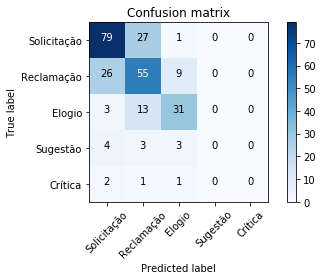

In [30]:
plt.figure()
classes = ['Solicitação','Reclamação','Elogio','Sugestão','Crítica']
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')

### Testando um registro único

In [31]:
text = df.Relato[0]
text = [vocab_to_int[word] for word in text.split()]
features = np.zeros((seq_len), dtype=int)
features[-len(text):] = np.array(text)[:seq_len]

In [32]:
features = np.expand_dims(features, axis=0)

In [33]:
prediction = model.predict(features)
prediction.argmax(axis=1)

array([0])

In [34]:
print("classe:", df.Natureza[0])
print('cod classe:',df['class'][0])
print("previsão:",prediction.argmax(axis=1)[0])
print("texto:",df.Relato[0])
print()
print("indices do vocabulario:", text)
print()
print("input da rede:",features[0])

classe: Solicitação
cod classe: 0
previsão: 0
texto: Boa tarde

Desde algum tempo que acompanho a vossa informação porque é de bastante interesse Desde já os meus parabéns
Gostaria de continuar a aceder ao vosso site sem ser necessário colocar o  CPF o estado e a cidade dado que não me enquadro pois sou português Como fazer para me cadastrar

Cumprimentos
Luís Espadana

indices do vocabulario: [65, 69, 203, 276, 144, 4, 6820, 5, 3263, 166, 120, 16, 1, 350, 262, 203, 44, 26, 189, 508, 67, 1, 601, 5, 6821, 22, 6822, 55, 72, 53, 483, 621, 3, 184, 3, 719, 2, 5, 221, 836, 4, 8, 17, 4375, 46, 149, 4376, 152, 43, 7, 17, 436, 4377, 3264, 6823]

input da rede: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   65   69  203  276  144    4 6820    5 3263  166  120
   16    1  350  262  203   44   26  189  508   67    1 

### Checando registros errados:

In [35]:
def text_to_input(text,vocab_to_int):
    text = [vocab_to_int[word] for word in text.split()]
    features = np.zeros((seq_len), dtype=int)
    features[-len(text):] = np.array(text)[:seq_len]
    features = np.expand_dims(features, axis=0)
    return features

In [36]:
for index in range(10):
    X_test_dummy = text_to_input(df.Relato[index],vocab_to_int)
    prediction = model.predict(features)
    prediction = prediction.argmax(axis=1)[0]
    if(prediction != df['class'][index]): #errou
        print("errou a previsao no indice:",index)
        print("texto:", df.Relato[index])
        print("classe prevista:", prediction)
        print("classe verdadeira:",df['class'][index])
        print("")

errou a previsao no indice: 1
texto: Sou Julio Cesar Freitas moro na cidade de Rio Branco e venho manifestar minha insatisfação com o atendimento no Sebrae-AC
Essa é a terceira vez em 2 anos que procuro o Sebrae local buscando  orientações e informações sobre como iniciar um negócio que idealizado mas não tenho tido “sorte”
O processo de atendimento parece não ter um fluxo padronizado A impressão que tive nas vezes que procurei atendimento é que existe um enorme abismo entre o serviço propagandeado pelo Sebrae e a realidade no atendimento
Quero dizer que o acolhimento - pelo menos inicial já que nunca consegui passar dele - não tem fluidez
Na minha experiência particularmente sempre apareceram obstáculos Não retorno de atendimento remarcações e imprevistos são alguns das ocorrências que marcam minha passagem pelo órgão
Resumindo numa frase a minha impressão do Sebrae-AC há um certo nível de falta de informação aliado a uma possível ausência de processo de fluxo no atendimento inicial q